In [1]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

%matplotlib inline
os.chdir('/data/arpit.goel/32_RecruitRestarauntPrediction/')

df_air_visit_data=pd.read_csv('01.RawData/air_visit_data.csv',parse_dates=['visit_date'])
df_date_info=pd.read_csv('01.RawData/date_info.csv',parse_dates=['calendar_date'])
df_sample_submission=pd.read_csv('01.RawData/sample_submission.csv')
df_store_master=pd.read_csv('02.CleanData/01.StoreRegion.csv')

In [26]:
TRAINING_WINDOW_WEEK=84 #Take 84 days as training window and get median weekday visits as benchmark
TRAINING_WINDOW_OVERALL=70 

def get_clean_trips(x):
    medians_weekday=x[-TRAINING_WINDOW_WEEK:]
    medians_weekday=medians_weekday.values.reshape(12,7)
    medians_weekday=pd.Series(np.tile(np.nanmedian(medians_weekday,axis=0),6))
    medians_weekday=medians_weekday.fillna(np.nanmedian(x[-TRAINING_WINDOW_OVERALL:]))
    medians_weekday.index=pd.date_range(start=datetime(2017,3,12),periods=42)
    return x[-42:].fillna(medians_weekday)
    
df_air_visit_data.loc[:,'log_visitors']=np.log(1+df_air_visit_data.loc[:,'visitors'])
daily_visits=df_air_visit_data.groupby(['air_store_id','visit_date'])['log_visitors'].max().unstack()
store_trips=daily_visits.apply(get_clean_trips,axis=1).dropna()


/home/arpit.goel2/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [51]:
store_trips_2d = TSNE(n_components=2, perplexity=5).fit_transform(store_trips)
df_store_master['a0']=df_store_master['store_id'].map(pd.Series(store_trips_2d[:,0],index=store_trips.index.tolist()))
df_store_master['a1']=df_store_master['store_id'].map(pd.Series(store_trips_2d[:,1],index=store_trips.index.tolist()))
df_plot=df_store_master[df_store_master['a0'].notnull()]


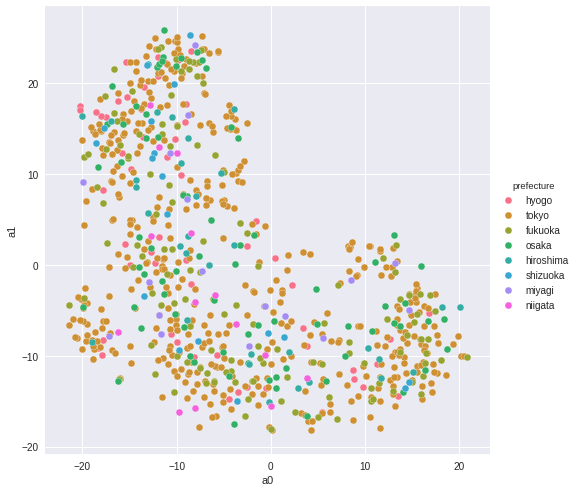

In [52]:
sns.pairplot(x_vars=['a0'], y_vars=['a1'], data=df_plot, hue='prefecture', size=7)

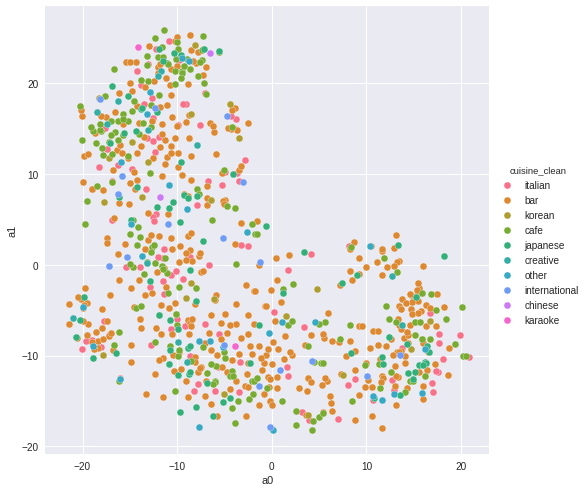

In [53]:
sns.pairplot(x_vars=['a0'], y_vars=['a1'], data=df_plot, hue='cuisine_clean', size=7)

In [54]:
from ggplot import *
chart = ggplot( df_tsne, aes(x='a0', y='a1', color='cuisine_clean') ) + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Cuisine")
chart

ModuleNotFoundError: No module named 'ggplot'

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(store_trips)
df_store_master['p0']=df_store_master['store_id'].map(pd.Series(pca_result[:,0],index=store_trips.index.tolist()))
df_plot=df_store_master[df_store_master['p0'].notnull()]


In [63]:
pd.crosstab(df_plot['cuisine_clean'],pd.qcut(df_plot['p0'],10))

p0,"[-12.811, -5.0499]","(-5.0499, -3.722]","(-3.722, -2.701]","(-2.701, -1.407]","(-1.407, -0.0549]","(-0.0549, 0.962]","(0.962, 2.122]","(2.122, 3.8]","(3.8, 5.424]","(5.424, 13.434]"
cuisine_clean,,,,,,,,,,
bar,26,33,33,37,35,37,46,42,43,51
cafe,31,21,19,11,24,14,14,17,12,17
chinese,1,0,0,1,0,0,0,0,0,0
creative,2,3,2,1,1,1,1,0,1,1
international,0,3,1,4,3,1,2,2,1,1
italian,11,12,14,13,11,11,8,7,11,4
japanese,6,8,7,9,5,9,8,8,11,6
karaoke,1,0,0,0,0,1,0,0,0,0
korean,2,2,4,3,2,3,2,3,0,2


In [64]:
pd.crosstab(df_plot['prefecture'],pd.qcut(df_plot['p0'],10))

p0,"[-12.811, -5.0499]","(-5.0499, -3.722]","(-3.722, -2.701]","(-2.701, -1.407]","(-1.407, -0.0549]","(-0.0549, 0.962]","(0.962, 2.122]","(2.122, 3.8]","(3.8, 5.424]","(5.424, 13.434]"
prefecture,,,,,,,,,,
fukuoka,14,9,13,9,11,10,19,11,15,16
hiroshima,2,6,2,6,2,2,1,5,4,2
hyogo,7,11,9,4,5,5,4,5,5,2
miyagi,1,1,2,2,2,2,3,2,1,1
niigata,0,3,0,2,2,3,1,3,0,0
osaka,10,7,4,5,12,7,6,8,7,8
shizuoka,3,3,2,2,2,1,1,2,2,0
tokyo,44,39,42,48,43,44,45,42,47,49
